In [69]:
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV, cross_val_score 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier

import string
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
train=pd.read_csv('/content/drive/My Drive/Colab Notebooks/kaggle/Titanic/data/train.csv')
test=pd.read_csv('/content/drive/My Drive/Colab Notebooks/kaggle/Titanic/data/test.csv')
submit = pd.read_csv('/content/drive/My Drive/Colab Notebooks/kaggle/Titanic/data/gender_submission.csv')

In [71]:
data=train.append(test)
data.reset_index(inplace=True,drop=True)

#EDA

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


Text(0.5, 1.0, 'Survival')

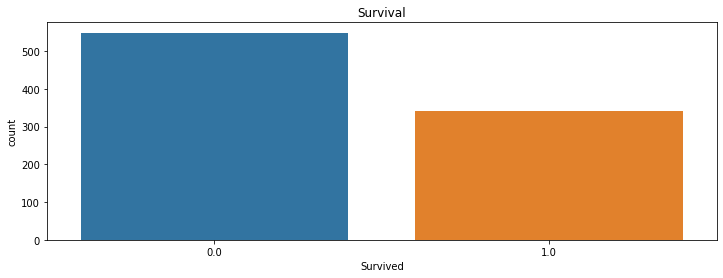

In [73]:
sns.countplot(data['Survived']).set_title('Survival')

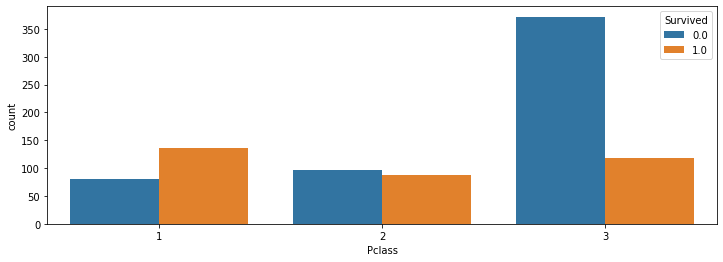

In [74]:
sns.countplot(data['Pclass'], hue=data['Survived'])

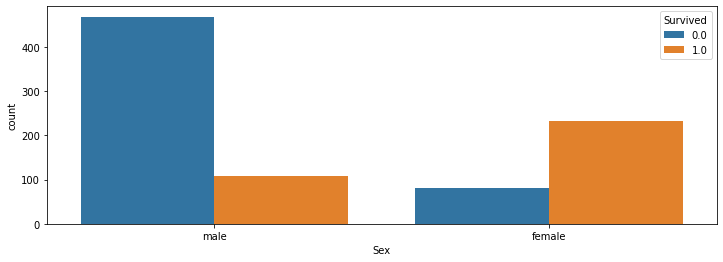

In [75]:
sns.countplot(data['Sex'], hue=data['Survived'])

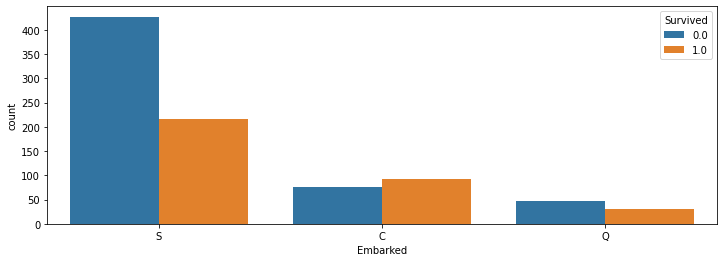

In [76]:
sns.countplot(data['Embarked'], hue=data['Survived'])

TypeError: ignored

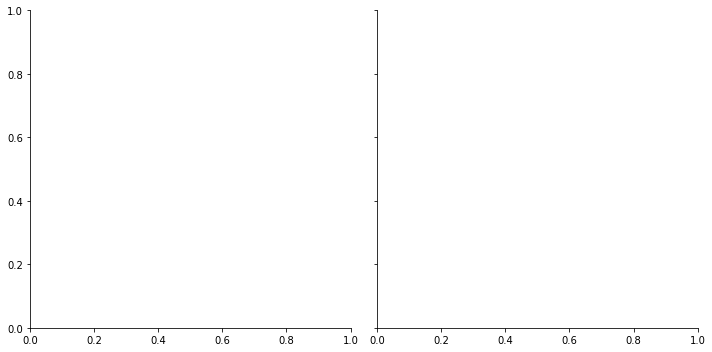

In [129]:
g=sns.FacetGrid(data, col='Survived', height=5)
g.map(sns.distplot, 'Age', kde=False)

TypeError: ignored

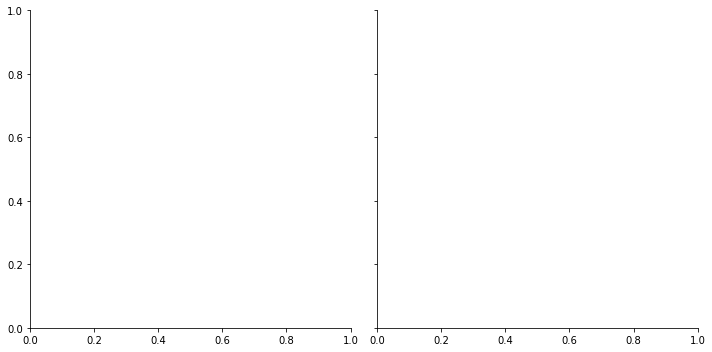

In [130]:
g=sns.FacetGrid(data, col='Survived', height=5)
g.map(sns.distplot, 'Fare', kde=False)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


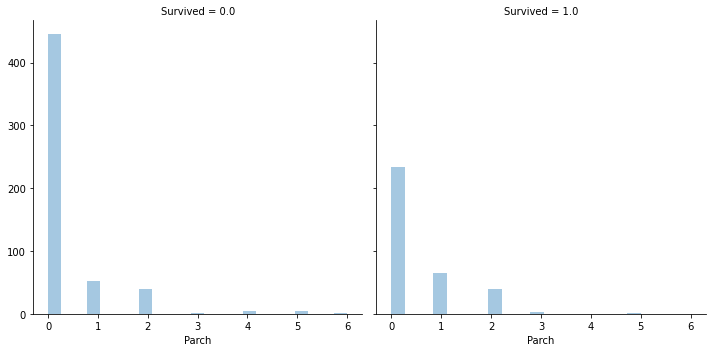

In [79]:
g = sns.FacetGrid(data, col='Survived', height=5)
g.map(sns.distplot, 'Parch', kde=False)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


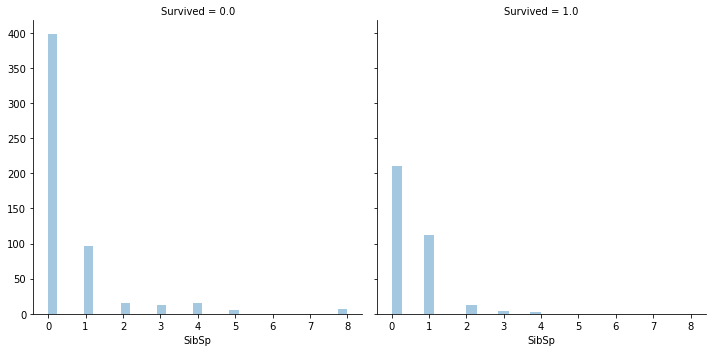

In [80]:
g = sns.FacetGrid(data, col='Survived', height=5)
g.map(sns.distplot, 'SibSp', kde=False)

#Feature Engineering

In [81]:
data['Family_Size']=data['Parch']+data['SibSp']+1

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


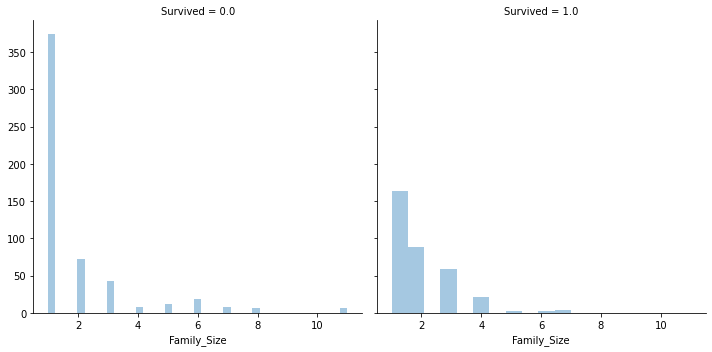

In [82]:
g = sns.FacetGrid(data, col='Survived', size=5)
g.map(sns.distplot, 'Family_Size', kde=False)

In [83]:
data['Title_tmp']=data['Name'].str.extract('([A-Za-z]+)\.', expand=False)

In [84]:
data['Title'] = data['Title_tmp'].replace(['Mlle','Mme','Ms','Dr','Major','Lady',
                                            'Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                                           ['Miss','Mrs','Miss','Mr','Mr','Mrs',
                                            'Mrs','Mr','Mr','Mr','Mr','Mr','Mr','Mrs'])

In [85]:
data['Is_married'] = np.where((data['Title']=='Mrs')|(data['SibSp']==0),1,0)
data['Is_alone']=np.where(data['Family_Size']==0,1,0)

In [86]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

In [87]:
data['Family'] = extract_surname(data['Name'])

In [88]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
data['Family_Size_Grouped'] = data['Family_Size'].map(family_map)

In [89]:
data['Ticket_Frequency'] = data.groupby('Ticket')['Ticket'].transform('count')

In [90]:
data['Ticket_Info'] = data['Ticket'].apply(lambda x : x.split(' ')[0].replace('/','').replace('.','') if not x.isdigit() else 'X')

In [91]:
#補空值
data['Embarked'] = data['Embarked'].fillna('S')
data['Fare'] = data.groupby(['Pclass','Parch', 'SibSp'])['Fare'].fillna(data['Fare'].median())
data['Cabin'] = data['Cabin'].apply(lambda x : str(x)[0] if not pd.isnull(x) else 'M')
data['Cabin'] = data['Cabin'].replace(['A','B','C','T'],'ABC')
data['Cabin'] = data['Cabin'].replace(['D','E'],'DE')
data['Age']=data.groupby(['Sex','Pclass'])['Age'].apply(lambda x : x.fillna(x.median()))

In [92]:
data['Fare'] = pd.qcut(data['Fare'], 4)
data['Age'] = pd.qcut(data['Age'], 5)

In [93]:
dataTrain = data[pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])
dataTest = data[~pd.notnull(data['Survived'])].sort_values(by=["PassengerId"])

In [94]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in dataTrain['Family'].unique() if x in dataTest['Family'].unique()]
non_unique_tickets = [x for x in dataTrain['Ticket'].unique() if x in dataTest['Ticket'].unique()]

df_family_survival_rate = dataTrain.groupby('Family')['Survived', 'Family','Family_Size'].median()
df_ticket_survival_rate = dataTrain.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
  # Checking a family exists in both training and test set, and has members more than 1
  if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
    family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
  # Checking a ticket exists in both training and test set, and has members more than 1
  if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
    ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [95]:
mean_survival_rate = np.mean(dataTrain['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(dataTrain)):
    if dataTrain['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[dataTrain['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(dataTest)):
    if dataTest['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[dataTest['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
dataTrain['Family_Survival_Rate'] = train_family_survival_rate
dataTrain['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
dataTest['Family_Survival_Rate'] = test_family_survival_rate
dataTest['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(dataTrain)):
    if dataTrain['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[dataTrain['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(dataTest)):
    if dataTest['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[dataTest['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
dataTrain['Ticket_Survival_Rate'] = train_ticket_survival_rate
dataTrain['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
dataTest['Ticket_Survival_Rate'] = test_ticket_survival_rate
dataTest['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [96]:
for df in [dataTrain, dataTest]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2    

In [97]:
drop_col=['Title_tmp','Ticket','Name','Family_Size','Family','SibSp','Parch','Ticket_Info',
          'PassengerId','Family_Survival_Rate','Family_Survival_Rate_NA','Ticket_Survival_Rate','Ticket_Survival_Rate_NA']
dataTrain = dataTrain.drop(drop_col,axis=1)
dataTest = dataTest.drop(drop_col,axis=1)

In [98]:
X_columns=list(dataTrain.columns)
X_columns.remove('Survived')

##Encoding
補充One hot encoding:
https://medium.com/@PatHuang/%E5%88%9D%E5%AD%B8python%E6%89%8B%E8%A8%98-3-%E8%B3%87%E6%96%99%E5%89%8D%E8%99%95%E7%90%86-label-encoding-one-hot-encoding-85c983d63f87

In [99]:
'''Label encoding兩個'''
non_numeric_features = ['Age', 'Fare']

for df in [dataTrain, dataTest]:
    for feature in non_numeric_features:
      df[feature] = LabelEncoder().fit_transform(df[feature])

In [100]:
'''one-hot encoding'''
#轉成str才能套ger_dummies
for df in [dataTrain, dataTest]:
  df['Pclass']=df['Pclass'].apply(lambda x : str(x))

In [101]:
cat_features = ['Pclass', 'Sex', 'Cabin', 'Embarked', 'Title', 'Family_Size_Grouped']
dataTrain=dataTrain.join(pd.get_dummies(dataTrain[cat_features]))
dataTrain=dataTrain.drop(cat_features,axis=1)
dataTest=dataTest.join(pd.get_dummies(dataTest[cat_features]))
dataTest=dataTest.drop(cat_features,axis=1)

In [102]:
X_columns_dummy=list(dataTrain.columns)
X_columns_dummy.remove('Survived')

In [103]:
X_train = StandardScaler().fit_transform(dataTrain[X_columns_dummy])
y_train = dataTrain['Survived']
X_test = StandardScaler().fit_transform(dataTest[X_columns_dummy])

#各種模型

##DNN

In [104]:
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Dropout
from keras.utils import np_utils  # 用來後續將 label 標籤轉為 one-hot-encoding
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [105]:
from keras import backend as K
K.clear_session()

In [106]:
input_layer=keras.layers.Input((28,))
x=Dense(units=64, kernel_initializer='normal', activation='relu')(input_layer)
x=BatchNormalization()(x)
x=Dense(units=64, kernel_initializer='normal', activation='relu')(x)
x=Dense(units=128, kernel_initializer='normal', activation='relu')(x)
# x=BatchNormalization()(x)
x=Dense(units=256, kernel_initializer='normal', activation='relu')(x)
# x=BatchNormalization()(x)
# x=Dense(units=512, kernel_initializer='normal', activation='relu')(x)
output_layer=Dense(units=2, kernel_initializer='normal', activation='sigmoid')(x)
model=keras.models.Model(inputs=input_layer, outputs=output_layer)

In [107]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [108]:
X_train_dnn=np.array(X_train).reshape(-1,28).astype(float)
y_train_dnn=np_utils.to_categorical(y_train) 

In [109]:
#提早終止
earlystop = EarlyStopping(monitor="val_accuracy", 
                          patience=10, 
                          verbose=1
                          )

In [110]:
#儲存最佳模型
model_ckpt = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/Kaggle/Titanic/code/DNN_best.h5", 
                             monitor="val_accuracy", 
                             save_best_only=True)

In [111]:
#學習率下降
reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_accuracy', 
                              patience=2, 
                              verbose=1)

In [112]:
train_history=model.fit(X_train_dnn, y_train_dnn, 
                        validation_split=0.15, 
                        epochs=200,
                        batch_size=100,
                        verbose=1,
                        shuffle=True,
                        callbacks=[earlystop, model_ckpt,reduce_lr]
                        )

Epoch 1/200
8/8 [==============================] - 0s 18ms/step - loss: 0.6688 - accuracy: 0.6262 - val_loss: 0.6679 - val_accuracy: 0.6493
Epoch 2/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5600 - accuracy: 0.7873 - val_loss: 0.5787 - val_accuracy: 0.7687
Epoch 3/200
8/8 [==============================] - 0s 5ms/step - loss: 0.4350 - accuracy: 0.8415 - val_loss: 0.4951 - val_accuracy: 0.8358
Epoch 4/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3667 - accuracy: 0.8468 - val_loss: 0.4752 - val_accuracy: 0.8881
Epoch 5/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3334 - accuracy: 0.8639 - val_loss: 0.4777 - val_accuracy: 0.8657
Epoch 6/200
1/8 [==>...........................] - ETA: 0s - loss: 0.2965 - accuracy: 0.8700
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
8/8 [==============================] - 0s 5ms/step - loss: 0.3193 - accuracy: 0.8600 - val_loss: 0.4582 - val_accuracy: 0.8806
Epoc

In [113]:
 scores = model.evaluate(X_train_dnn, y_train_dnn)  
 scores

28/28 [==============================] - 0s 2ms/step - loss: 0.4027 - accuracy: 0.8833


[0.4027411639690399, 0.8832772374153137]

In [ ]:
model = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/Kaggle/Titanic/code/DNN_best.h5")
predict=model.predict(X_test)
predict=np.argmax(predict,axis=1)

In [ ]:
submit['Survived']=predict.astype('int')
submit.to_csv('/content/drive/My Drive/Colab Notebooks/Kaggle/Titanic/data/submit_dnn.csv', index= False)

In [114]:
def show_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train_acc', 'val_acc'], loc='upper left')
    plt.show()

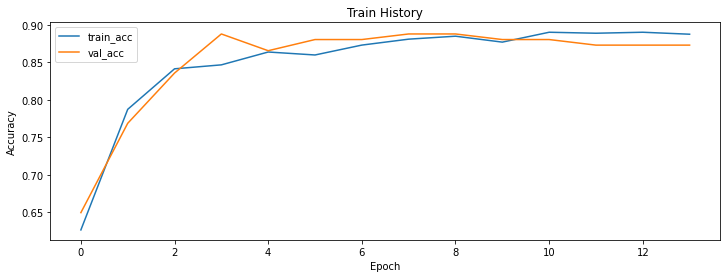

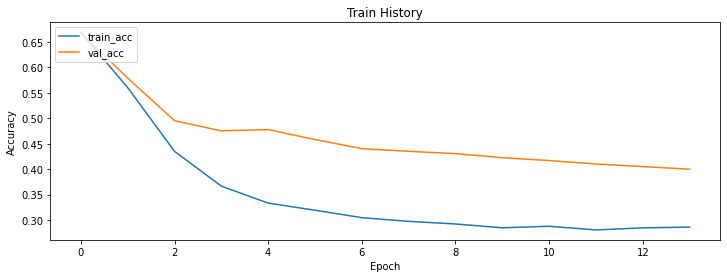

In [115]:
show_train_history('accuracy','val_accuracy')
show_train_history('loss','val_loss')

##XGBoost
參考資料
1. https://zhuanlan.zhihu.com/p/106432182
2. https://www.twblogs.net/a/5db37e49bd9eee310ee694ee

In [116]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import sklearn.metrics as metrics

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
target = 'Survived'

In [117]:
'''調參原則，先調模型架構，再調每棵樹細部設定'''
#data 要先處理成矩陣才能放進CV
dtrain = xgb.DMatrix(X_train,y_train)
#先固定一些常用值(後續還會網格調參)
params = {
    'obj':'binary:logistic',
    'max_depth':5,
    'learning_rate':0.1,
    'silent':1,
    'colsample_bytree':0.8,
    'subsample':0.8
}
#用CV找出迭帶次數
cvresult = xgb.cv(params, dtrain, num_boost_round=250, nfold=5, early_stopping_rounds=50,
       metrics={'map'}, seed=0)
len(cvresult)  #因為沒進步(50次)就會停止，列數就是最佳次數

16

In [118]:
#調整樹結果相關的參數
#max_depth, min_child_weight, gamma, subsample, colsample_bytree
param_test1 = {
 'max_depth':range(3,10,1),
 'min_child_weight':range(1,6,1)
}
xgbm=XGBClassifier(learning_rate =0.1, n_estimators=16, max_depth=4,
              min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
              objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=42)
gsearch1 = GridSearchCV(estimator = xgbm,
                        param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 4, 'min_child_weight': 5}, 0.8529345301613208)

In [119]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
xgbm=XGBClassifier(learning_rate =0.1, n_estimators=16, max_depth=4,
                   min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                   objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=42)
gsearch3 = GridSearchCV(estimator = xgbm,
                        param_grid = param_test2, scoring='accuracy',
                        n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'gamma': 0.0}, 0.8529345301613208)

In [120]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
xgbm=XGBClassifier(learning_rate =0.1, n_estimators=16, max_depth=4,
                   min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                   objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=42)
gsearch4 = GridSearchCV(estimator = xgbm,
                        param_grid = param_test3, scoring='accuracy',
                        n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.8529345301613208)

In [121]:
param_test4 = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
xgbm=XGBClassifier(learning_rate =0.1, n_estimators=16, max_depth=4,
                   min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                   objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=42)
gsearch6 = GridSearchCV(estimator = xgbm,
                        param_grid = param_test4, scoring='accuracy',
                        n_jobs=-1,iid=False, cv=5)
gsearch6.fit(X_train,y_train)
gsearch6.best_params_, gsearch6.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'reg_alpha': 0}, 0.8529345301613208)

In [122]:
#正規化項再調更細
param_test5 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
xgbm=XGBClassifier(learning_rate =0.1, n_estimators=82, max_depth=4,
                   min_child_weight=2, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                   objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=42)
gsearch7 = GridSearchCV(estimator = xgbm,
                        param_grid = param_test5, scoring='roc_auc',
                        n_jobs=-1,iid=False, cv=5)
gsearch7.fit(X_train,y_train)
gsearch7.best_params_, gsearch7.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'reg_alpha': 0.001}, 0.9212833442475151)

In [123]:
xgbm=XGBClassifier(learning_rate =0.05, n_estimators=32, max_depth=4,
                   min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                   objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=42)
cross_val_score(xgbm, X_train, y_train, cv=5).mean()
xgbm.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=None, n_estimators=32, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, verbosity=1)

In [124]:
#xgbm_res=xgbm.predict_proba(X_test)  #直接出0、1
xgbm_proba=xgbm.predict_proba(X_test)[:,1] #出機率

##RandomForest

In [125]:
RFmodel = RandomForestClassifier(criterion='gini',
                                 n_estimators=1900,
                                 max_depth=5,
                                 min_samples_split=3,
                                 min_samples_leaf=5,
                                 oob_score=True,
                                 random_state=42,
                                 n_jobs=-1,
                                #  verbose=1
                                 ) 

In [ ]:
#調參
param_test = {'n_estimators':range(1800,2000,50), 'max_depth':range(3,6), 'min_samples_split':range(3,6), 'min_samples_leaf':range(3,6)}
gsearch = GridSearchCV(estimator = RFmodel,
                       param_grid = param_test,iid=False,cv=5)
 
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

In [127]:
cross_val_score(RFmodel, X_train, y_train, cv=5).mean()

0.850681062080221

In [128]:
RFmodel.fit(X_train, y_train)
print(f'{RFmodel.oob_score_:4f}')

0.849607


In [ ]:
#rf_res=RFmodel.predict(X_test) #出0、1
rf_proba=RFmodel.predict_proba(X_test)[:,1] #出機率

##bagging

In [ ]:
res_proba=0.9*rf_proba+0.1*xgbm_proba
res=np.where(res_proba>0.5,1,0)

In [ ]:
submit['Survived']=res.astype('int')
submit.to_csv('/content/drive/My Drive/Colab Notebooks/Kaggle/Titanic/data/submit.csv', index= False)

#沒用到的處理

In [ ]:
#去除Age、Fare的離群
dataAgeNull=data[data['Age'].isnull()]
dataAgeNotNull=data[data['Age'].notnull()]
outlier_rule1=(abs(dataAgeNotNull['Age']-dataAgeNotNull['Age'].mean())>(4*dataAgeNotNull['Age'].std()))
outlier_rule2=(abs(dataAgeNotNull['Fare']-dataAgeNotNull['Fare'].mean())>(4*dataAgeNotNull['Fare'].std()))
remove_outlier=dataAgeNotNull[~(outlier_rule1|outlier_rule2)]

In [ ]:
#用模型填補空的Age
ageColumns = ['Pclass', 'Sex', 'Fare', 'Cabin', 'Embarked', 'Family_Size', 'Title', 'Ticket_Info']

In [ ]:
#GradientBoosting Model
GBodel=GradientBoostingRegressor(random_state=42)

In [ ]:
#調參
param_test = {'n_estimators':range(50,150,1)}
gsearch = GridSearchCV(estimator = GBodel,
                       param_grid = param_test,iid=False,cv=5)

gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

In [ ]:
ageNullValues = Model_age.predict(dataAgeNull[ageColumns])
dataAgeNull.loc[:,'Age'] = ageNullValues
data = dataAgeNull.append(dataAgeNotNull)
data.reset_index(inplace=True, drop=True)

In [ ]:
#label encoding
df=dataTrain.append(dataTest)
for c in df.columns:
  if df[c].dtype=='O':
    df[c] = LabelEncoder().fit_transform(df[c])